In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# responses = []
# with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
#     for row in tqdm(thefile):
#         resp = json.loads(row)
#         if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
#             responses.append(resp)

201030it [01:38, 2034.70it/s]


In [5]:
# list(responses[0].keys())

['city',
 'rating_not_checked',
 'title',
 'num_comments',
 'bank_license',
 'author',
 'bank_name',
 'datetime',
 'text',
 'rating_grade']

In [6]:
# df = [] 
# for i in responses:
#     df.append(list(i.values()))

In [3]:
data = pd.read_csv('data.csv')
# data = pd.DataFrame(df)
# data.columns = list(responses[0].keys())
data.head()

,Unnamed: 0,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,lenotz
0,0,г москва,False,жалоба,0,лицензия № 2562,uhnov1,бинбанк,2015-06-08 12:50:54,добрый день я не являюсь клиентом банка и пору...,NaN,213
1,1,г новосибирск,False,не могу пользоваться услугой сбербанк он лайн,0,лицензия № 1481,Foryou,сбербанк россии,2015-06-08 11:09:57,доброго дня являюсь держателем зарплатной карт...,NaN,135
2,2,г москва,False,двойное списание за один товар,1,лицензия № 2562,Vladimir84,бинбанк,2015-06-05 20:14:28,здравствуйте дублирую свое заявление от в до м...,NaN,83
3,3,г ставрополь,False,меняют проценты комиссии не предупредив и не и...,2,лицензия № 1481,643609,сбербанк россии,2015-06-05 13:51:01,добрый день я открыл расчетный счет в сбербанк...,NaN,121
4,4,г челябинск,False,верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,отп банк,2015-06-05 10:58:12,г взяла кредит в вашем банке заявленная мною с...,NaN,291


In [64]:
import re
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    if text != None:
        return " ".join(regex.findall(text.lower()))
    else:
        return None

In [9]:
data['city'] = data['city'].apply(words_only)
data['title'] = data['title'].apply(words_only)
data['text'] = data['text'].apply(words_only)
data['bank_name'] = data['bank_name'].apply(words_only)

In [10]:
data.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г москва,False,жалоба,0,лицензия № 2562,uhnov1,бинбанк,2015-06-08 12:50:54,добрый день я не являюсь клиентом банка и пору...,NaN
1,г новосибирск,False,не могу пользоваться услугой сбербанк он лайн,0,лицензия № 1481,Foryou,сбербанк россии,2015-06-08 11:09:57,доброго дня являюсь держателем зарплатной карт...,NaN
2,г москва,False,двойное списание за один товар,1,лицензия № 2562,Vladimir84,бинбанк,2015-06-05 20:14:28,здравствуйте дублирую свое заявление от в до м...,NaN
3,г ставрополь,False,меняют проценты комиссии не предупредив и не и...,2,лицензия № 1481,643609,сбербанк россии,2015-06-05 13:51:01,добрый день я открыл расчетный счет в сбербанк...,NaN
4,г челябинск,False,верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,отп банк,2015-06-05 10:58:12,г взяла кредит в вашем банке заявленная мною с...,NaN


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [11]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [12]:
# 1. Посчитайте количество отзывов в разных городах и на разные банки

data.groupby(['city', 'bank_name']).count()[['text']]

text
city     bank_name             
г        авангард            10
         ак барс              1
         альфа банк          15
         амт банк             2
         балтийский банк      2
...                         ...
г яхрома дельтакредит         1
         сбербанк россии      1
         ситибанк             1
г яшалта россельхозбанк       1
г яшкино хоум кредит банк     1

[16650 rows x 1 columns]

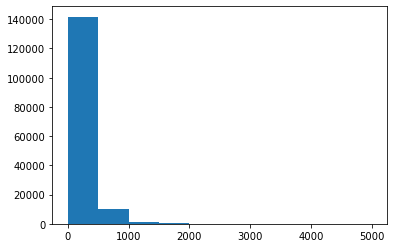

In [13]:
# 2. Постройте гистограмы длин слов в символах и в словах. 
# судя по формулировке, все таки "количества слов в отзывах и символов в словах"

data['lenotz'] = data['text'].apply(lambda x: len(x.split()))
plt.hist(data['lenotz'])
plt.show()

In [14]:
words = ' '.join(list(data['text'])).split(sep=' ')
words[:30]

# lwords = 

['добрый',
 'день',
 'я',
 'не',
 'являюсь',
 'клиентом',
 'банка',
 'и',
 'поручителем',
 'по',
 'кредитному',
 'договору',
 'а',
 'также',
 'не',
 'являюсь',
 'каким',
 'либо',
 'другим',
 'лицом',
 'письменно',
 'оформившим',
 'отношения',
 'с',
 'банком',
 'по',
 'поводу',
 'урегулирования',
 'чьей',
 'либо']

In [15]:
lwords = []
for i in words:
    lwords.append(len(i))
    
lw = pd.DataFrame(lwords)

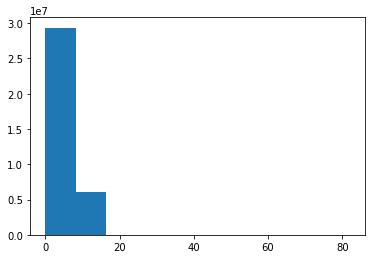

In [16]:
plt.hist(lw)
plt.show()

In [17]:
# 10 самых частых слов

wd = pd.DataFrame(words)
wd['count'] = 1
popular = wd.groupby(0).count().reset_index()
popular.columns = ['word', 'count']
popular.sort_values(by='count', ascending=False).head(10)

,word,count
17789,в,1330550
69045,и,1058997
113200,не,855335
105950,на,707935
257941,что,640057
264391,я,577500
207539,с,464037
157777,по,372769
102084,мне,320958
8543,банка,275906


In [58]:
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']

print(mystopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [19]:
popularnotstop = popular.loc[~popular['word'].isin(mystopwords)]
popularnotstop.sort_values(by='count', ascending=False).head(10)

,word,count
8543,банка,275906
8542,банк,215426
44242,деньги,131201
78505,карту,105829
78517,карты,101821
87867,кредит,81136
44235,день,76552
8572,банке,72169
66969,заявление,70423
147045,очень,66824


In [18]:
from pymystem3 import Mystem
m = Mystem()

In [21]:
# popularnotstop['lemma'] = popularnotstop['word'].apply(m.lemmatize)

In [22]:
# так как лемматизация - процесс долгий, предположим, что самые популярные леммы порождаются из самых популярных
# слов
# pop = popularnotstop.sort_values(by='count', ascending=False).head(1000)

In [10]:
# pop['lemma'] = pop['word'].apply(m.lemmatize)

,Unnamed: 0,word,count,lemma
0,8543,банка,275906,банка
1,8542,банк,215426,банк
2,44242,деньги,131201,деньги
3,78505,карту,105829,карта
4,78517,карты,101821,карта


In [11]:
# pop.lemma = pop.lemma.apply(lambda x: x[0])

,Unnamed: 0,word,count,lemma
0,8543,банка,275906,банка
1,8542,банк,215426,банк
2,44242,деньги,131201,деньги
3,78505,карту,105829,карта
4,78517,карты,101821,карта


In [65]:
pop.groupby('lemma').sum().sort_values(by='count', ascending=False).reset_index().head(10)[['lemma','count']]

,lemma,count
0,банк,360242
1,карта,326897
2,банка,303863
3,деньги,178591
4,день,163710
5,мой,160498
6,кредит,149113
7,который,146717
8,отделение,139728
9,клиент,134278


In [76]:
pop[pop['lemma'].isin(['сотрудник', 'клиент', 'мошенничество', 'доверие'])].groupby('lemma').sum()[['count']]

,count
lemma,
клиент,134278
сотрудник,133550


In [48]:
# считаем существительные на базе топ-1000 лемм (так как на всей базе очень долго работает pymystem)

def noun(word):
    try: 
        part = m.analyze(word)[0]['analysis'][0]['gr'][0]
    except:
        return False    
    if part == 'S':
        return True
    else:
        return False

[{'analysis': [], 'text': 'sex'}, {'text': '\n'}]

In [64]:
# pop['noun'] = pop['lemma'].apply(noun)

In [59]:
# итого существительных
pop[pop['noun'] == True]['count'].sum()

6881733

In [4]:
pop = pd.read_csv('pop.csv')
pop.head()

,Unnamed: 0,word,count,lemma
0,8543,банка,275906,банка
1,8542,банк,215426,банк
2,44242,деньги,131201,деньги
3,78505,карту,105829,карта
4,78517,карты,101821,карта


In [14]:
# кривая ципфа (каждое следующее слово встречается в N раз реже самого популярного)
# N - порядок слова в тексте

pop['ciph'] = 1/(pop['count']/pop['count'][0])

pop.head(10)

,Unnamed: 0,word,count,lemma,ciph
0,8543,банка,275906,банка,1.000000
1,8542,банк,215426,банк,1.280746
2,44242,деньги,131201,деньги,2.102926
3,78505,карту,105829,карта,2.607093
4,78517,карты,101821,карта,2.709716
5,87867,кредит,81136,кредит,3.400537
6,44235,день,76552,день,3.604164
7,8572,банке,72169,банк,3.823054
8,66969,заявление,70423,заявление,3.917839
9,147045,очень,66824,очень,4.128846


<AxesSubplot:>

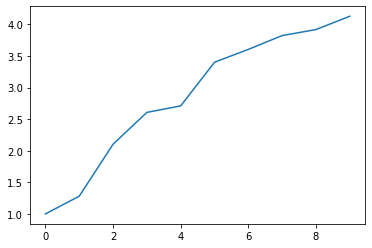

In [13]:
pop.head(10)['ciph'].plot()
# в нашем случае закон Ципфа не подтвердился

In [21]:
# кривая Хипса (зависимость количества разных слов от длины текста)

data['text'] = data['text'].apply(lambda x: set(str(x).split()))
data.head()

,Unnamed: 0,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,lenotz
0,0,г москва,False,жалоба,0,лицензия № 2562,uhnov1,бинбанк,2015-06-08 12:50:54,"{неудобства, разыскиваете, вреда, договору, фи...",NaN,213
1,1,г новосибирск,False,не могу пользоваться услугой сбербанк он лайн,0,лицензия № 1481,Foryou,сбербанк россии,2015-06-08 11:09:57,"{токарева, подключить, являюсь, зарплатной, ро...",NaN,135
2,2,г москва,False,двойное списание за один товар,1,лицензия № 2562,Vladimir84,бинбанк,2015-06-05 20:14:28,"{моей, один, разобраться, раза, с, смс, по, и,...",NaN,83
3,3,г ставрополь,False,меняют проценты комиссии не предупредив и не и...,2,лицензия № 1481,643609,сбербанк россии,2015-06-05 13:51:01,"{удосужился, предупредив, при, перевода, догов...",NaN,121
4,4,г челябинск,False,верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,отп банк,2015-06-05 10:58:12,"{документами, при, рассматривается, принесла, ...",NaN,291


In [27]:
data['lenset'] = data['text'].apply(lambda x: len(x))
data.head()

,Unnamed: 0,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,lenotz,lenset
0,0,г москва,False,жалоба,0,лицензия № 2562,uhnov1,бинбанк,2015-06-08 12:50:54,"{неудобства, разыскиваете, вреда, договору, фи...",NaN,213,157
1,1,г новосибирск,False,не могу пользоваться услугой сбербанк он лайн,0,лицензия № 1481,Foryou,сбербанк россии,2015-06-08 11:09:57,"{токарева, подключить, являюсь, зарплатной, ро...",NaN,135,106
2,2,г москва,False,двойное списание за один товар,1,лицензия № 2562,Vladimir84,бинбанк,2015-06-05 20:14:28,"{моей, один, разобраться, раза, с, смс, по, и,...",NaN,83,64
3,3,г ставрополь,False,меняют проценты комиссии не предупредив и не и...,2,лицензия № 1481,643609,сбербанк россии,2015-06-05 13:51:01,"{удосужился, предупредив, при, перевода, догов...",NaN,121,90
4,4,г челябинск,False,верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,отп банк,2015-06-05 10:58:12,"{документами, при, рассматривается, принесла, ...",NaN,291,170


<AxesSubplot:xlabel='lenotz'>

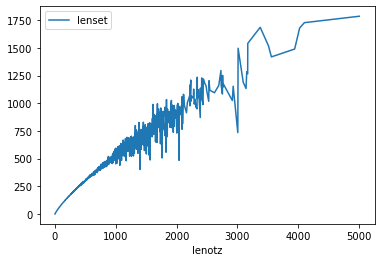

In [33]:
data.sort_values(by='lenotz', ascending=True)[['lenotz','lenset']].groupby('lenotz').median().plot()